#### Cluster DNA repair deficient samples 

## 1 Pre-processing

In [32]:
%load_ext autoreload
%autoreload 2
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from qtl.norm import deseq2_normalized_counts, inverse_normal_transform
import plotly.express as px
import json
from scipy.cluster import hierarchy
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import umap

sys.path.append("../funcs/")
import plotting as pl
import utils

import rpy2.rinterface
%load_ext rpy2.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# PATHS
SAMPLE_PATH = "gs://cptac-pancan-getzlab/Final_Submission_Files/PanCan_Participant_freeze_mapping.tsv"
DENDRO_PATH = "gs://cptac-pancan-getzlab/Final_Submission_Files/Supplemental_2/dendrogram_split_map.tsv"
PHOSPHO_COHORT_CORRECTED_PATH = "gs://cptac-pancan-getzlab/Freeze_061721/061721/raw/phosphoproteome_raw_res_X.tsv"
PHOSPHO_RAW_PATH = "gs://cptac-pancan-getzlab/Freeze_061721/061721/raw/phosphoproteome_X.tsv.gz"
H_MUT_PATH = "gs://cptac-pancan-getzlab/Final_Submission_Files/Supplemental_3/Full_H_compressed_v2.tsv"

MULTIOMIC_H_PATH = "../analysis_files/H_matrix_multiomic_nmf.tsv"
NMF_PATH = "../analysis_files/nmf_output.h5"
# MULTIOMIC_H_PATH = "/home/yakiyama/CPTAC_PanCan_2021/analysis_files/H_matrix_multiomic_nmf.tsv"
# NMF_PATH = "/home/yakiyama/CPTAC_PanCan_2021/analysis_files/nmf_output.h5"


In [120]:
# Read data
sample_df = pd.read_csv(SAMPLE_PATH, sep='\t')
H_mut = pd.read_csv(H_MUT_PATH, sep='\t', index_col=0)
dendro_df = pd.read_csv(DENDRO_PATH, sep='\t', index_col=0)
multiomic_h_df = pd.read_csv(MULTIOMIC_H_PATH, sep='\t', index_col=0)
h_raw_df = pd.read_hdf(NMF_PATH, "Hraw")
dendro_df['cohort'] = dendro_df.index.map(
    sample_df.set_index('Proteome_Sample_ID').to_dict()['cohort'])

In [121]:
# Standardize sample IDs
H_mut.index = H_mut.index.map(sample_df.set_index('WXS').to_dict()['Proteome_Sample_ID'])

# Subset for shared patients
H_mut = H_mut.loc[np.intersect1d(H_mut.index.astype(str), dendro_df.index.astype(str))]

# Define DDR tumors
mmrd_tumors = H_mut[H_mut['MMRD']>0].index
hrd_tumors = H_mut[H_mut['HRD']>=45].index

# Assign DDR status
dendro_df['MMR_status'] = dendro_df.index.map(lambda x: "MMRD" if x in mmrd_tumors else "MMRP")
dendro_df['HR_status'] = dendro_df.index.map(lambda x: "HRD" if x in hrd_tumors else "HRP")


## 2 HRD PCA
Project multi-omic signatures onto PCA for all HRD tumors

In [139]:
# Annotate samples with pan-cancer dendrogram assignments
dendro_df['HRD_clust'] = dendro_df.apply(lambda x: '3A' if x['3'] == True else 
                                    ('3B' if x['3']==False else 
                                     ('2A' if x['2']==True else 
                                      '2B')), 1)

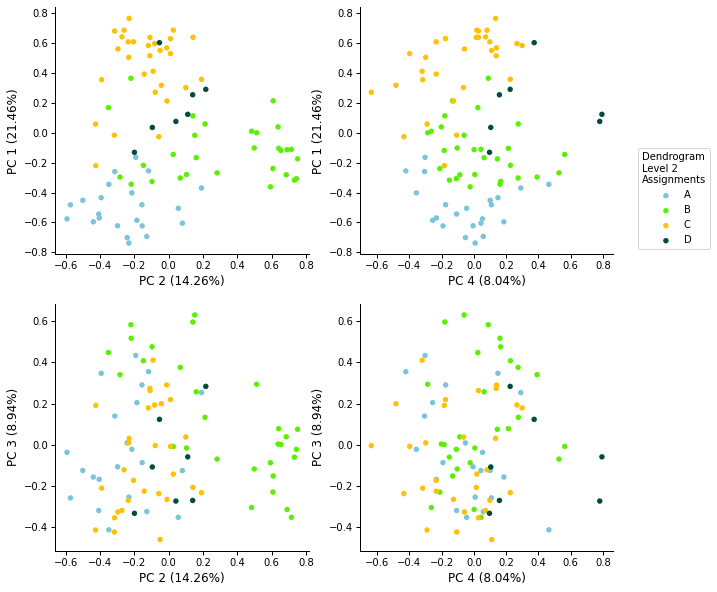

In [140]:
# Map for dendrogram splits A/B to L/R
dendrosplit_d = {"3A":"A", "3B":"B", "2A":"C", "2B":"D"}

# Dendrogram assignment colors
# dendro_colors = {"A": "#D81B60", "B": "#1E88E5", 
#                  "C": "#FFC107", "D":"#004D40"}
dendro_colors = {"A": "#7AC5DB", "B": "#5BF003", 
                 "C": "#FFC107", "D":"#004D40"}
cohort_color_d = {'BRCA':'#cd6090', 'HGSC':'#cdb4db', 'PDAC':'#962a13'}

# Subset multi-omic signatures for HRD tumors and normalize/scale to zero center
hrd_h_df = h_raw_df.loc[:,hrd_tumors].copy()
hrd_h_norm_df = hrd_h_df - hrd_h_df.mean(axis=0)
hrd_h_norm_df = hrd_h_norm_df / np.sqrt(hrd_h_norm_df.pow(2).sum(axis=0))

# Project multi-omic signatures onto PCA
P_df, pca, gns = utils.get_pcs(hrd_h_norm_df, normalize=False, return_genes=True, C=None)

fig, axes = pl.plot_pca_grid(hrd_h_norm_df, normalize=False, 
                          cohort_s=dendro_df['HRD_clust'].map(dendrosplit_d), 
                          title='', cohort_colors=dendro_colors, retFig=True)
axes[0,1].legend(title="Dendrogram\nLevel 2\nAssignments", loc="lower right",
                 bbox_to_anchor=(1.4,0))

# Save PCA output. Annotate dataframe with dendrogram assignments
P_df['HRD_clust'] = P_df.index.map(dendro_df.to_dict()['HRD_clust']).map(dendrosplit_d)
P_df['cohort'] = P_df.index.map(sample_df.set_index('Proteome_Sample_ID').to_dict()['cohort'])
P_df['color'] = P_df['cohort'].map(cohort_color_d)

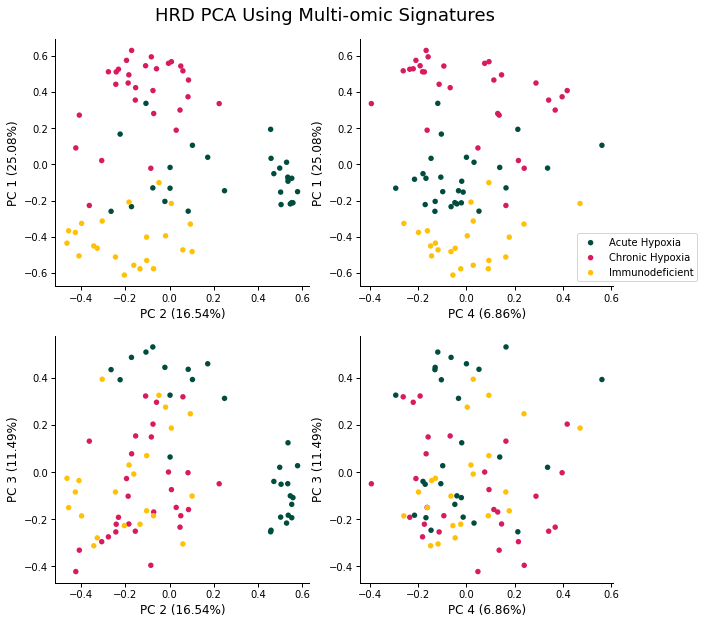

In [38]:
# For AACR poster
hrd_cluster_h_df = cluster_h_df.loc[hrd_tumors].T.copy()
hrd_cluster_h_norm_df = hrd_cluster_h_df - hrd_cluster_h_df.mean(axis=0)
hrd_cluster_h_norm_df = hrd_cluster_h_norm_df / np.sqrt(hrd_cluster_h_norm_df.pow(2).sum(axis=0))

include_samples = hrd_cluster_h_norm_df.columns[hrd_cluster_h_norm_df.columns.map(
    dendro_df['lvl2'].to_dict()) != "2B"]
hrd_cluster_h_norm_df = hrd_cluster_h_norm_df[include_samples]

dendro_colors = {"Chronic Hypoxia": "#D81B60", "Immunodeficient": "#FFC107", 
                 "Acute Hypoxia":"#004D40"}

P_df, pca, gns = utils.get_pcs(hrd_cluster_h_norm_df, normalize=False, return_genes=True, C=None)
P_raw_df, pca_raw, gns_raw = utils.get_pcs(hrd_cluster_h_df, normalize=False, return_genes=True, C=None)

# Map for dendrosplits
dendrosplit_d = {"3A":"Immunodeficient", "3B":"Acute Hypoxia", "2A":"Chronic Hypoxia"}
fig, axes = plot_pca_grid(hrd_cluster_h_norm_df, normalize=False, 
                          cohort_s=dendro_df['lvl2'].map(dendrosplit_d), 
                          title='HRD PCA Using Multi-omic Signatures', cohort_colors=dendro_colors)

In [68]:
%%R
library(ggplot2)
library(ggpubr)

In [141]:
int_rstr = {0:"X0", 1:"X1", 2:"X2", 3:"X3", 4:"X4"}
P_df.columns = P_df.columns.map(lambda x: x if x not in int_rstr else int_rstr[x])

In [142]:
%R -i P_df

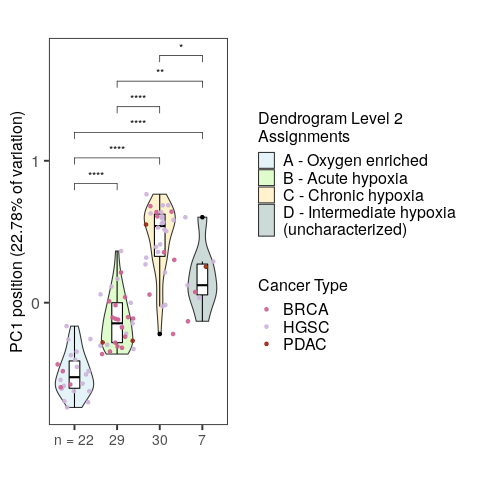

In [143]:
%%R
P_df$HRD_clust <- factor(P_df$HRD_clust, 
                               levels = c('A','B', 'C', 'D'), 
                               ordered = TRUE)
comparisons_l <- list(c("A", "B"), c("A","C"), 
                      c("A", "D"), c("B", "C"), 
                      c("B", "D"), c("C", "D"))

pc1_violin <- ggplot(P_df, aes(x = HRD_clust, y = X0)) +
  geom_violin(aes(fill = HRD_clust), varwidth = T, alpha = 0.2) +
  geom_boxplot(width=0.25, colour="black") +
  geom_jitter(alpha = 0.9, aes(color=color)) +
  scale_fill_manual(values=c("#7AC5DB","#5BF003", "#FFC107", "#004D40"), 
                    breaks=c("A", "B", "C", "D"), 
                    labels=c("A - Oxygen enriched", "B - Acute hypoxia", 
                             "C - Chronic hypoxia", 
                             "D - Intermediate hypoxia \n(uncharacterized)")) +
  scale_color_manual(values=c('#cd6090','#cdb4db', '#962a13'), 
                     breaks=c('#cd6090','#cdb4db', '#962a13'), 
                     labels=c("BRCA", "HGSC", "PDAC")) +
  scale_x_discrete(labels=c("n = 22", "29", "30", "7")) +
  theme_bw(base_size = 20) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
        axis.text.x = element_text(size=14),
        plot.title=element_text(size=18), legend.title=element_text(size=16), 
        legend.text=element_text(size=16), axis.title=element_text(size=16)) +
  labs(title="", y= "PC1 position (22.78% of variation)", x= "", 
       fill="Dendrogram Level 2\nAssignments", color="Cancer Type") +
  stat_compare_means(label = "p.signif", method = "wilcox.test",
                     comparison=comparisons_l)
pdf("figures/Figure_3C_pca_dendrogram_violin.pdf", w=10,  h=6)
print(pc1_violin)
dev.off()
pc1_violin

## 3.2 Analyze PC1

In [17]:
gns

array(['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11',
       'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
       'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29',
       'S30', 'S31', 'S32', 'S33', 'max', 'max_id', 'max_norm'],
      dtype=object)

In [18]:
pca.components_[1]


array([ 0.72662709, -0.02313566,  0.00487053, -0.02942355, -0.07944529,
       -0.00881652, -0.01149246, -0.13047092, -0.00295578,  0.00769701,
        0.02642547,  0.03507236, -0.5577646 , -0.00274544,  0.09375739,
        0.01518138,  0.01390264, -0.05589288,  0.02584202, -0.07966677,
        0.03791934, -0.0522237 , -0.10169281, -0.16951917,  0.00832652,
        0.19622267,  0.06976566, -0.0494888 , -0.00692564,  0.10134393,
        0.00240464, -0.04774121, -0.07814957,  0.07493853,  0.02131606,
        0.02593752])

In [19]:
np.argsort(abs(pca.components_[1]))[::-1]

array([ 0, 12, 25, 23,  7, 22, 29, 14, 19,  4, 32, 33, 26, 17, 21, 27, 31,
       20, 11,  3, 10, 35, 18,  1, 34, 15, 16,  6,  5, 24,  9, 28,  2,  8,
       13, 30])

In [20]:
pca.components_[1][np.argsort(abs(pca.components_[1]))[::-1]]

array([ 0.72662709, -0.5577646 ,  0.19622267, -0.16951917, -0.13047092,
       -0.10169281,  0.10134393,  0.09375739, -0.07966677, -0.07944529,
       -0.07814957,  0.07493853,  0.06976566, -0.05589288, -0.0522237 ,
       -0.0494888 , -0.04774121,  0.03791934,  0.03507236, -0.02942355,
        0.02642547,  0.02593752,  0.02584202, -0.02313566,  0.02131606,
        0.01518138,  0.01390264, -0.01149246, -0.00881652,  0.00832652,
        0.00769701, -0.00692564,  0.00487053, -0.00295578, -0.00274544,
        0.00240464])

# 4 Cluster MMRD Tumors
Project multi-omic signatures for every MMRD tumor onto PCA

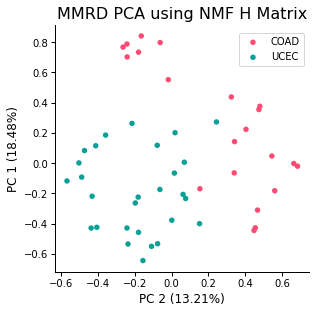

In [112]:
# PCA of COAD and UCEC samples
ucec_coad_mmrd_tumors_l = [sample for sample in mmrd_tumors if dendro_df.loc[sample,'cohort'] in ['COAD', 'UCEC']]
mmrd_cluster_h_df = h_raw_df[ucec_coad_mmrd_tumors_l].copy()
mmrd_cluster_h_norm_df = mmrd_cluster_h_df - mmrd_cluster_h_df.mean(axis=0)
mmrd_cluster_h_norm_df = mmrd_cluster_h_norm_df / np.sqrt(mmrd_cluster_h_norm_df.pow(2).sum(axis=0))

P_df, pca, gns = utils.get_pcs(mmrd_cluster_h_norm_df, normalize=False, return_genes=True, C=None)
P_raw_df, pca_raw, gns_raw = utils.get_pcs(mmrd_cluster_h_df, normalize=False, return_genes=True, C=None)

f, ax = pl.plot_pca_grid(mmrd_cluster_h_df, normalize=False, 
                         cohort_s=dendro_df['cohort'], 
                         title='', retFig=True)
ax[0,1].remove()
ax[1,0].remove()
ax[1,1].remove()
ax[0,0].set_title("MMRD PCA using NMF H Matrix", size=16)
ax[0,0].legend(loc='center right', bbox_to_anchor=(1, 0.9))

In [113]:
# Sort signatures by their explained variance in PC 2
np.argsort(abs(pca.components_[1]))[::-1]

array([ 3, 11, 27, 29, 17, 20, 16,  5, 32,  4, 19,  6, 22,  7, 18, 13,  8,
       24, 12, 21, 30,  0,  9, 10, 23, 15, 31, 28, 26, 25, 14,  1,  2])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'MMRD UMAP')

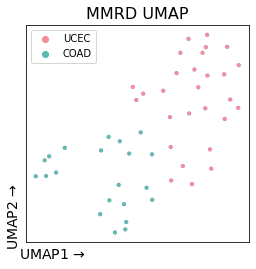

In [81]:
# UMAP of COAD and UCEC Samples
mmrd_umap_df = mmrd_cluster_h_df.copy().T
fit = umap.UMAP(random_state=42)
H_umap = fit.fit_transform(mmrd_umap_df)
mmrd_umap_df['umap1'] = H_umap[:,0]
mmrd_umap_df['umap2'] = H_umap[:,1]

f, ax = plt.subplots(1, 1, figsize=(4,4))
pl.plot_umap(mmrd_umap_df, dendro_df.loc[ucec_coad_mmrd_tumors_l, 'cohort'], 
             s=16, ax=ax)
ax.set_xlabel(r"UMAP1 $\to$", fontsize=14)
ax.set_ylabel(r"UMAP2 $\to$", fontsize=14)
ax.set_title("MMRD UMAP", size=16)